# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).

## 1. Data exploration.

In [47]:
# Required libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

import torch as t
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import KMNIST
from torchsummary import summary

from tqdm import tqdm
import time

t.manual_seed(999)

### Import dataset and first look at the images

In [48]:
BATCH_SIZE = 32

# Convert data to PyTorch tensor form and normalise it
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
data_transforms = transforms.Compose([transforms.ToTensor()])

kwargs = {'num_workers': 10, 'pin_memory': True} # GPU

## download and load training dataset
trainset = KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# download and load test dataset 
testset = KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

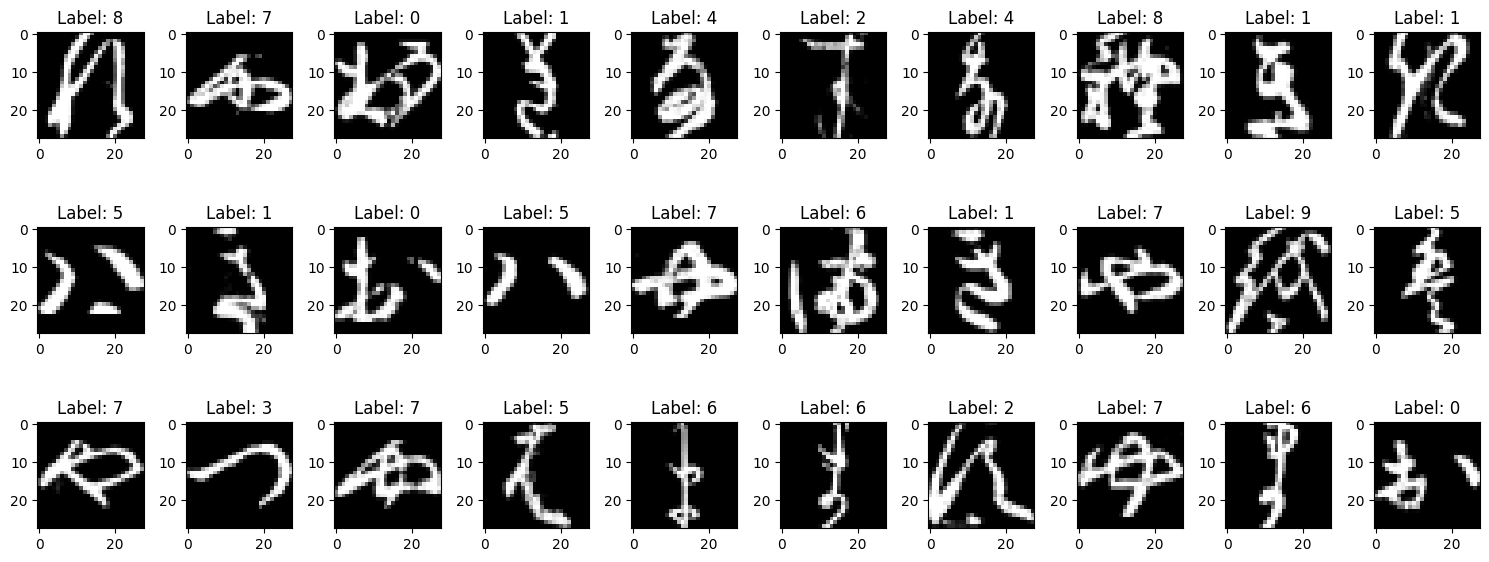

In [49]:
num_row = 3
num_col = 10

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [50]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


(60000, 1, 28, 28) (60000,)


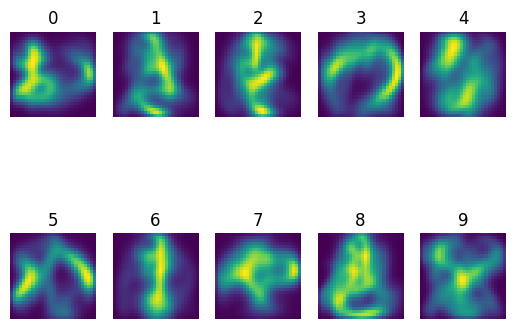

In [51]:
explore_X,explore_y = [],[]
for i in range(len(trainloader)):
    
    for X,y in trainloader:    
        explore_X.append(X.numpy())
        explore_y.append(y.numpy())
    break

explore_X,explore_y = np.array(explore_X).reshape([60000,1,28,28]),np.array(explore_y).reshape([1875*32])
print(explore_X.shape,explore_y.shape)

def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index]

def get_mean_images():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_image = class_arrayX.mean(axis=0)
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.title(i)
        plt.imshow(mean_image.squeeze())
        
get_mean_images()

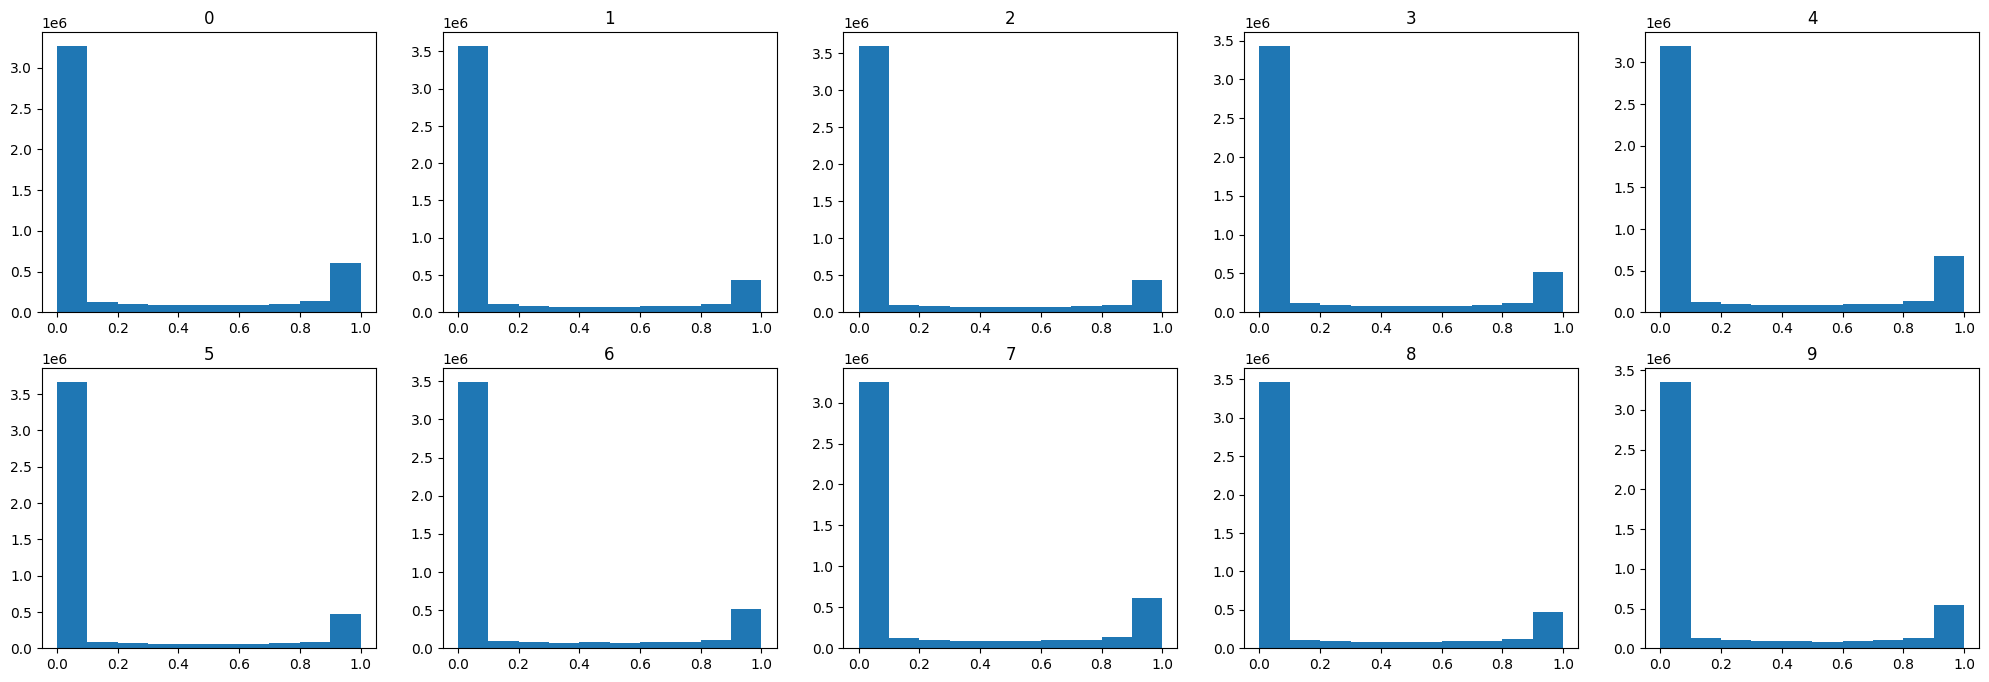

In [52]:
figure = plt.figure(figsize=(25,8))

def get_histogram():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX.reshape(-1))
        plt.title(i)

get_histogram()

[0.21728402, 0.16558969, 0.1629944, 0.18987574, 0.232921, 0.15998814, 0.18470773, 0.22099517, 0.18213382, 0.20113173]


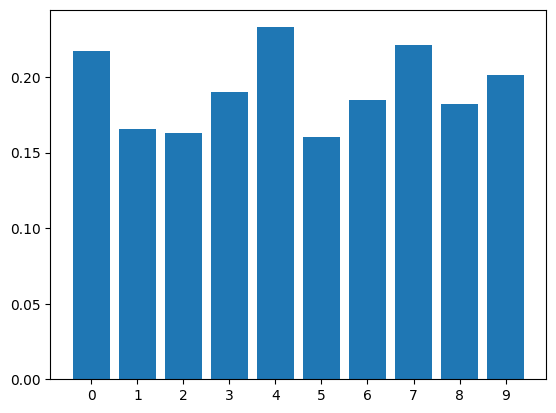

In [53]:
def get_mean_barchart():
    mean_values =[]
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean())
    
    plt.bar(np.arange(10),mean_values, align='center')
    plt.xticks(np.arange(10))
    print(mean_values)

get_mean_barchart()

In [54]:
explore_X.shape

(60000, 1, 28, 28)

### Dimension reduction for better comprension of the dataset

#### PCA

In [55]:
pca = PCA(n_components=2)
proj = pca.fit_transform(explore_X.reshape(-1,784))

In [56]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.10869143 0.05363858]


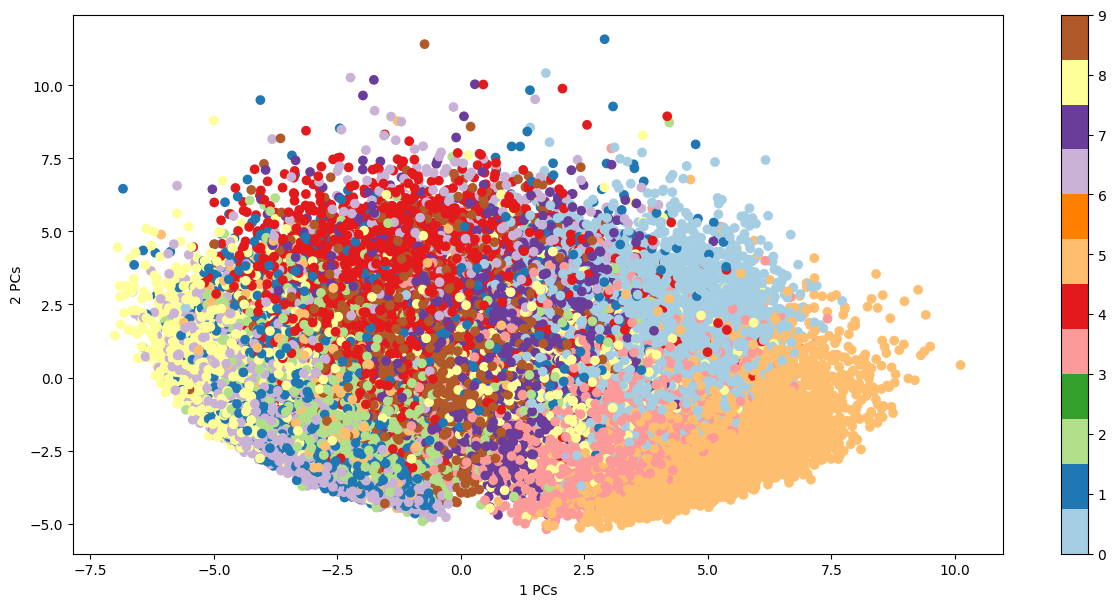

In [57]:
figure = plt.figure(figsize=(15,7))
plt.scatter(proj[:, 0], proj[:, 1], c=explore_y, cmap="Paired")
plt.colorbar(ticks=range(10))
plt.xlabel("1 PCs")
plt.ylabel("2 PCs")
plt.show()


In [58]:
pca = PCA(n_components=3)
proj = pca.fit_transform(explore_X.reshape(-1,784))

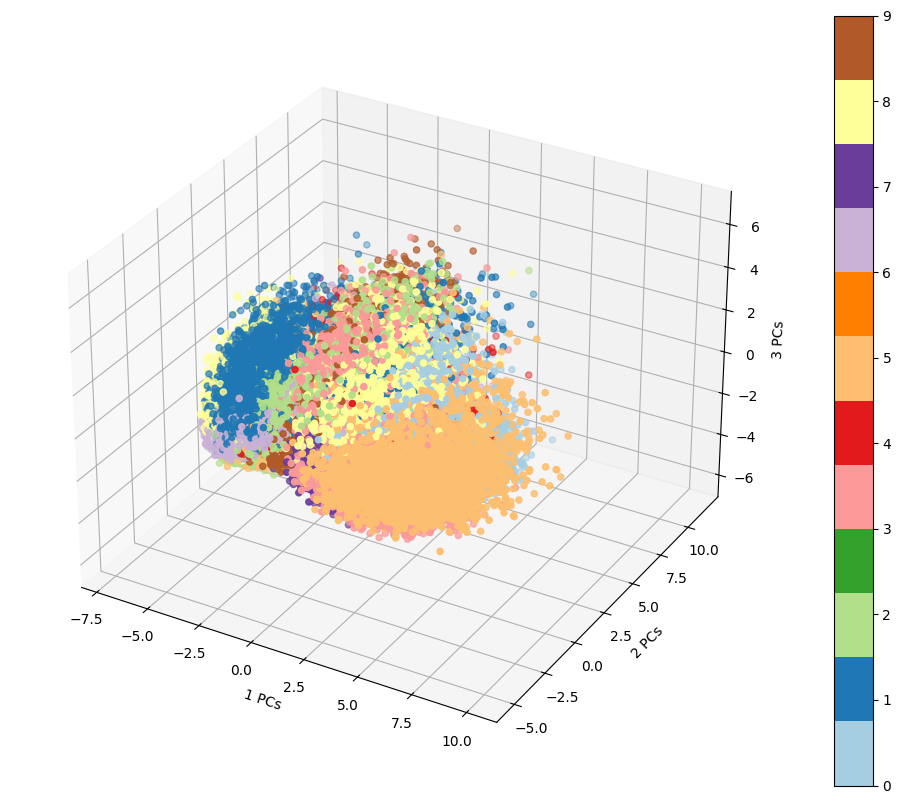

In [59]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c=explore_y, cmap="Paired")

# Add labels
ax.set_xlabel('1 PCs')
ax.set_ylabel('2 PCs')
ax.set_zlabel('3 PCs')

ax.set_box_aspect(aspect=None, zoom=0.96)

cbar = fig.colorbar(scatter, ticks=np.linspace(0, 9, 10))
plt.show()


In [60]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.10869141 0.05363863 0.04091232]


Text(0.5, 0.98, '3-Component PCA')

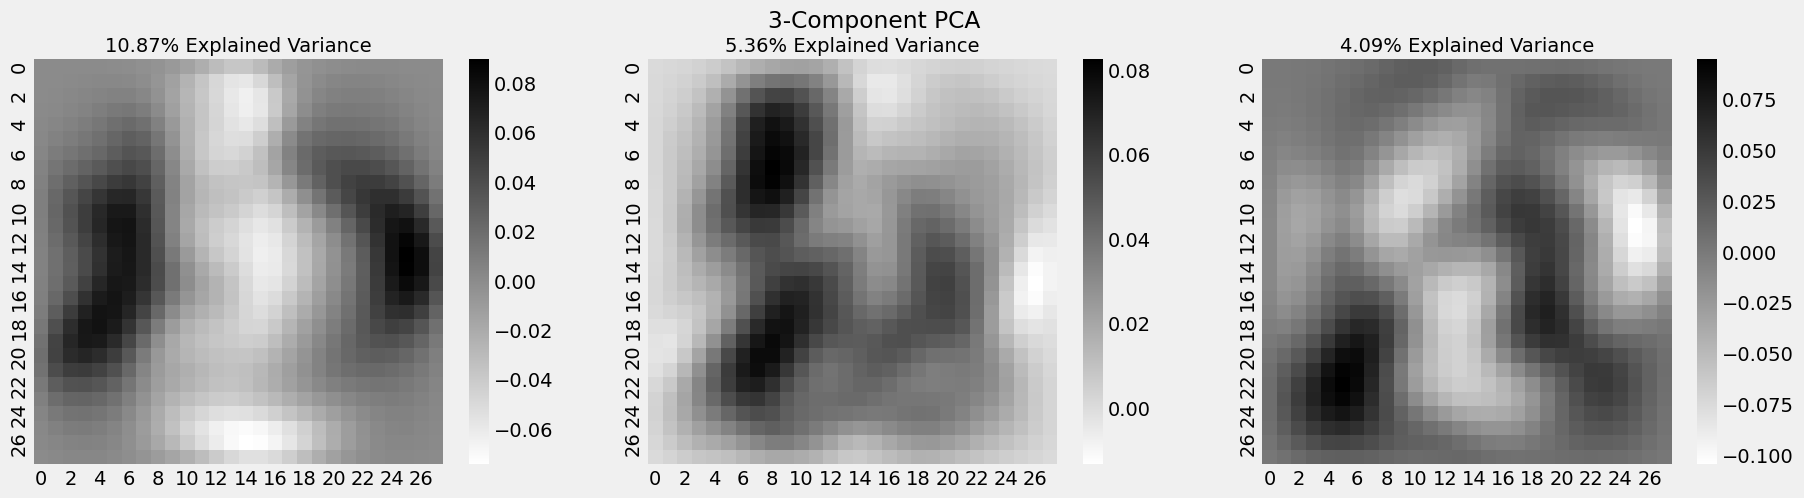

In [61]:
# Set the graph style as 'fivethirtyeight'
plt.style.use('fivethirtyeight')
#Set figure size
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
# use seaborn heatmap to visualize the first three pca components
sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap=plt.cm.binary)
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap=plt.cm.binary)
sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[2], cmap=plt.cm.binary)
# Set picture title to explained variance
axarr[0].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100), fontsize=14)
axarr[1].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100), fontsize=14)
axarr[2].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100), fontsize=14)
# Add picture title
plt.suptitle('3-Component PCA')

In [62]:
# initializing the pca
# Set n_components as 784 dimensions
pca = PCA(n_components=28*28)
proj = pca.fit_transform(explore_X.reshape(-1,784))
#percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
var_ratios = np.cumsum(pca.explained_variance_ratio_)

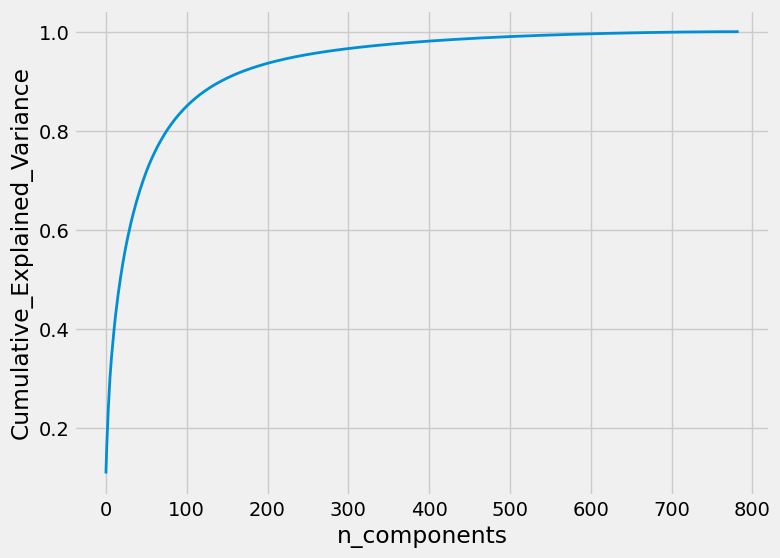

In [63]:
# Plot the PCA spectrum
plt.figure(figsize=(8, 6))
plt.plot(var_ratios, linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Cumulative_Explained_Variance")
plt.show()

#### t-SNE

In [64]:
# Keep track of time elapsed in the method
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(explore_X.reshape(-1,28*28))
print('t-SNE finished! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.024s...
[t-SNE] Computed neighbors for 60000 samples in 30.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

[]

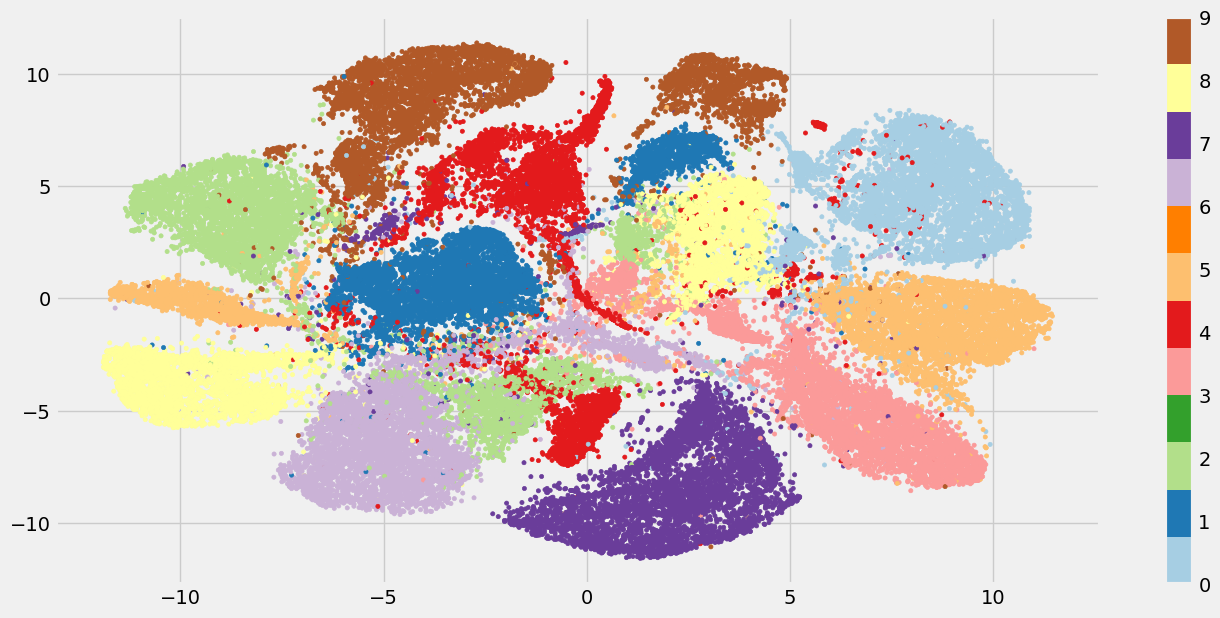

In [65]:
figure = plt.figure(figsize=(15,7))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=explore_y, cmap="Paired", marker='.')
plt.colorbar(ticks=range(10))
plt.plot()

In [66]:
def get_class_embeddings_arrays(class_index):
    return tsne_results[explore_y==class_index],explore_y[explore_y==class_index]

C:\Users\Davide\AppData\Local\Temp\ipykernel_26712\2292240531.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("Paired", 10), marker='.')


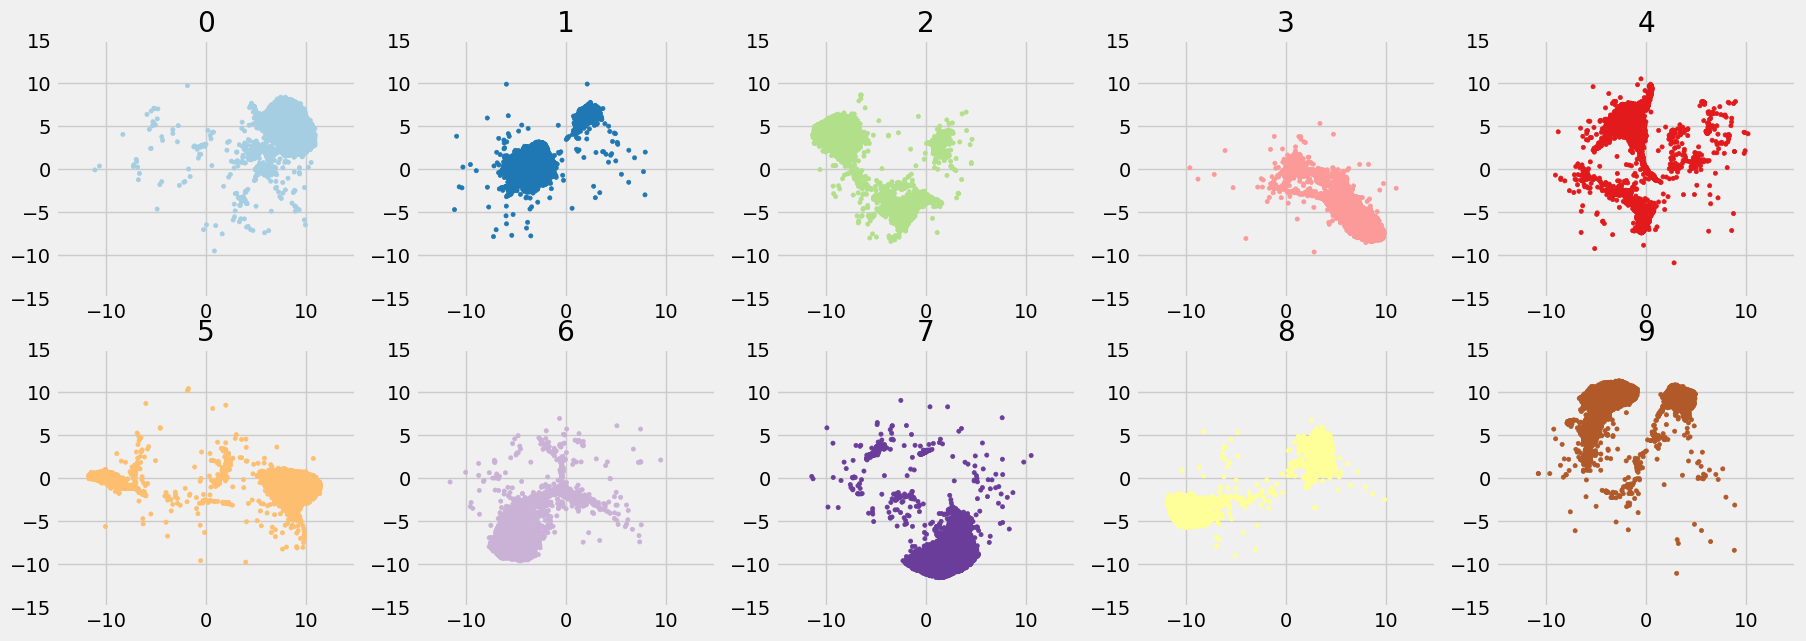

In [67]:
figure = plt.figure(figsize=(20,7))

for i in range(10):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("Paired", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-15, 15, -15, 15])
    plt.title(i)

## 2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.

In [68]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [69]:
# functions

def get_accuracy(logit, target):
    corrects = (t.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += t.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, testloader, criterion, optimizer):

    #device = t.device("cuda" if t.cuda.is_available() else "cpu")

    #model = model.to(device)

    train__losses = []
    train_accs = []
    test__losses = []
    test_accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode: relevant for dropout, batchnorm, etc.
        model = model.train()
        ## training step
        loop_train = tqdm(enumerate(trainloader), total=len(trainloader))
        for i, (images, labels) in loop_train:

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero: otherwise they accumulate!
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
            
            loop_train.set_description(f"Train Epoch: \t[{epoch+1}/{num_epochs}]")
            loop_train.set_postfix(loss = train_running_loss/(i+1) , acc=train_acc/(i+1))

        train__losses.append(train_running_loss / (i+1))
        train_accs.append(train_acc/(i+1))
        model.eval()

        loop_test = tqdm(enumerate(testloader), total=len(testloader))
        for i, (images, labels) in loop_test:

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            test_running_loss += loss.item()
            test_acc += get_accuracy(logits, labels)
            
            loop_test.set_description(f"Test Epoch: \t[{epoch+1}/{num_epochs}]") 
            loop_test.set_postfix(loss = test_running_loss/(i+1) , acc=test_acc/(i+1))

        test__losses.append(test_running_loss / (i+1))
        test_accs.append(test_acc/(i+1))

        norms.append(compute_weight_norm(model))

    return train__losses, train_accs, test__losses, test_accs, norms

Let's start with a simple model:
- Convolutional 2d
- Fully connected
- Fully connected

Here's the number of neurons:
 - input -> convolutional = 28x28 
 - Convolutional -> first fc = 32x26x26
 - First fc -> Second fc = 128
 - Seconf fc -> output = 10

Tot = 22.554  
Tot n. of parameters = 2770634

In [70]:
class ConvLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvLinLin, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.l1 = nn.Linear(32 * 26 * 26, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = x.flatten(start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx128 => BSx10
        out = self.l2(x)

        return out
    
model = ConvLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Linear-2                  [-1, 128]       2,769,024
            Linear-3                   [-1, 10]           1,290
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 10.57
Estimated Total Size (MB): 10.74
----------------------------------------------------------------


In [71]:
def plot_loss_accs(train_losses, test_losses, train_accs, test_accs):
    figure = plt.figure(figsize=(15,4))

    labels = ["train loss","test loss"]

    plt.subplot(1,2,1)
    plt.plot(train_losses,label = labels[0])
    plt.plot(test_losses,label = labels[1])
    plt.legend(loc="upper right")

    labels = ["train accuracy","test accuracy"]
    plt.subplot(1,2,2)

    plt.plot(train_accs,label = labels[0])
    plt.plot(test_accs,label = labels[1])
    plt.legend(loc="lower right")
    plt.show()

In [72]:
num_epochs = 10

model_ConvLinLin_Adam = ConvLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ConvLinLin_Adam.parameters(), lr=0.001)

ConvLinLin_Adam_result = train_model(model_ConvLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)


Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 44.40it/s, acc=91.7, loss=0.586] 


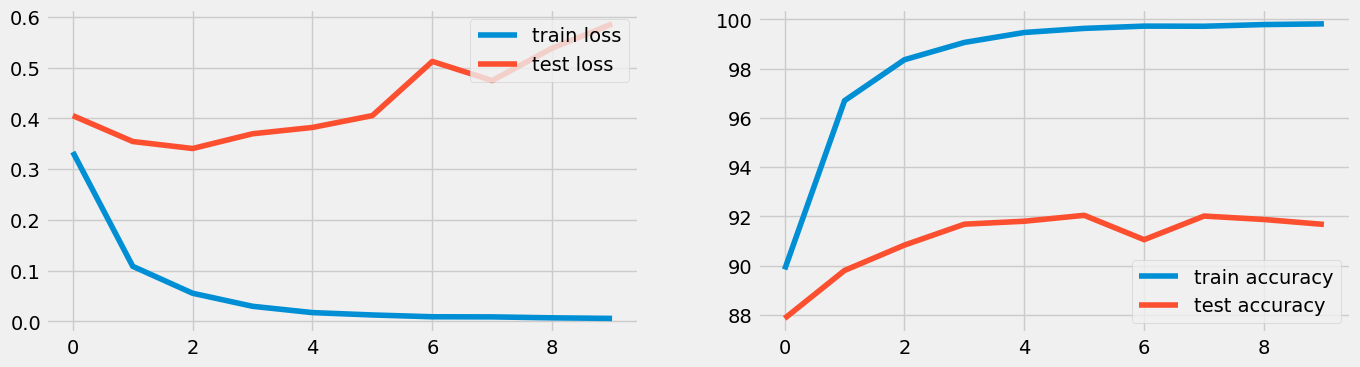

In [73]:
plot_loss_accs(ConvLinLin_Adam_result[0], ConvLinLin_Adam_result[2], ConvLinLin_Adam_result[1], ConvLinLin_Adam_result[3])

Second model:
- Convolutional 2d + MaxPooling
- Fully connected
- Fully connected

Here's the number of neurons:
 - input -> convolutional + maxpooling = 28x28 
 - Convolutional -> first fc = 32x8x8
 - First fc -> Second fc = 128
 - Seconf fc -> output = 10

 Tot = 2970  
 Tot n. of parameters = 263882

In [74]:
class ConvMpolLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolLinLin, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.mpol1 = nn.MaxPool2d(kernel_size=3)
        self.l1 = nn.Linear(32 * 8 * 8, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # BSx32x26x26 => BSx32x8x8
        x = self.mpol1(x)

        # flatten => BS x (32*8*8) = BS x 2832
        x = x.flatten(start_dim = 1)

        # BSx(32*8*8) => BSx128
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx128 => BSx10
        out = self.l2(x)

        return out
    
model = ConvMpolLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2             [-1, 32, 8, 8]               0
            Linear-3                  [-1, 128]         262,272
            Linear-4                   [-1, 10]           1,290
Total params: 263,882
Trainable params: 263,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 1.01
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


In [75]:
num_epochs = 10

model_ConvMpolLinLin_Adam = ConvMpolLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ConvMpolLinLin_Adam.parameters(), lr=0.001)

ConvMpolLinLin_Adam_result = train_model(model_ConvMpolLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:06<00:00, 46.97it/s, acc=93.7, loss=0.331] 


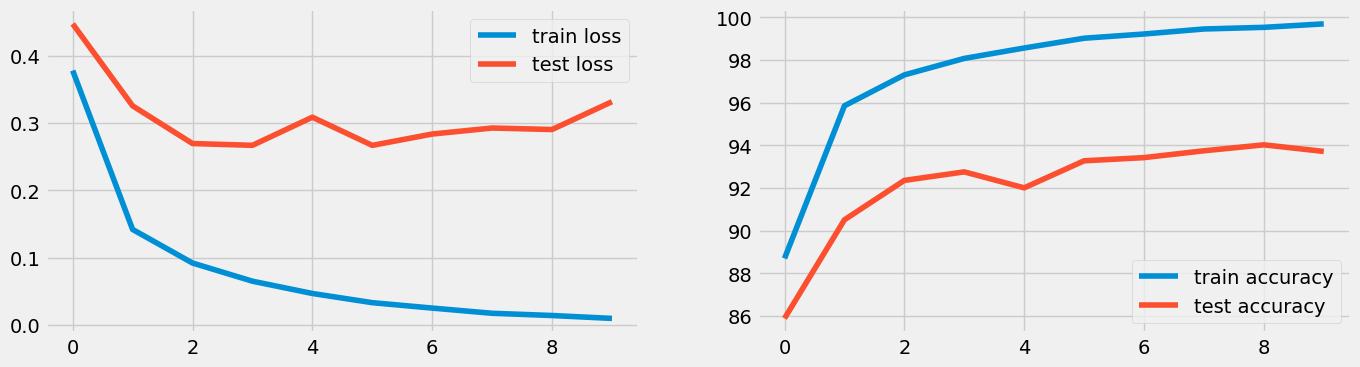

In [76]:
plot_loss_accs(ConvMpolLinLin_Adam_result[0], ConvMpolLinLin_Adam_result[2], ConvMpolLinLin_Adam_result[1], ConvMpolLinLin_Adam_result[3])

Second model:
- Convolutional 2d + AvgPooling
- Fully connected
- Fully connected

Here's the number of neurons:
 - input -> convolutional + avgpooling = 28x28 
 - Convolutional -> first fc = 32x8x8
 - First fc -> Second fc = 128
 - Seconf fc -> output = 10

 Tot = 2970  
 Tot n. of parameters = 263882

In [77]:
class ConvApolLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvApolLinLin, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.apol1 = nn.AvgPool2d(kernel_size=3)
        self.l1 = nn.Linear(32 * 8 * 8, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # BSx32x26x26 => BSx32x8x8
        x = self.apol1(x)

        # flatten => BS x (32*8*8) = BS x 2832
        x = x.flatten(start_dim = 1)

        # BSx(32*8*8) => BSx128
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx128 => BSx10
        out = self.l2(x)

        return out

model = ConvApolLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         AvgPool2d-2             [-1, 32, 8, 8]               0
            Linear-3                  [-1, 128]         262,272
            Linear-4                   [-1, 10]           1,290
Total params: 263,882
Trainable params: 263,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 1.01
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


In [78]:
num_epochs = 10

model_ConvApolLinLin_Adam = ConvApolLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ConvApolLinLin_Adam.parameters(), lr=0.001)

ConvApolLinLin_Adam_result = train_model(model_ConvApolLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:06<00:00, 44.73it/s, acc=93.7, loss=0.311] 


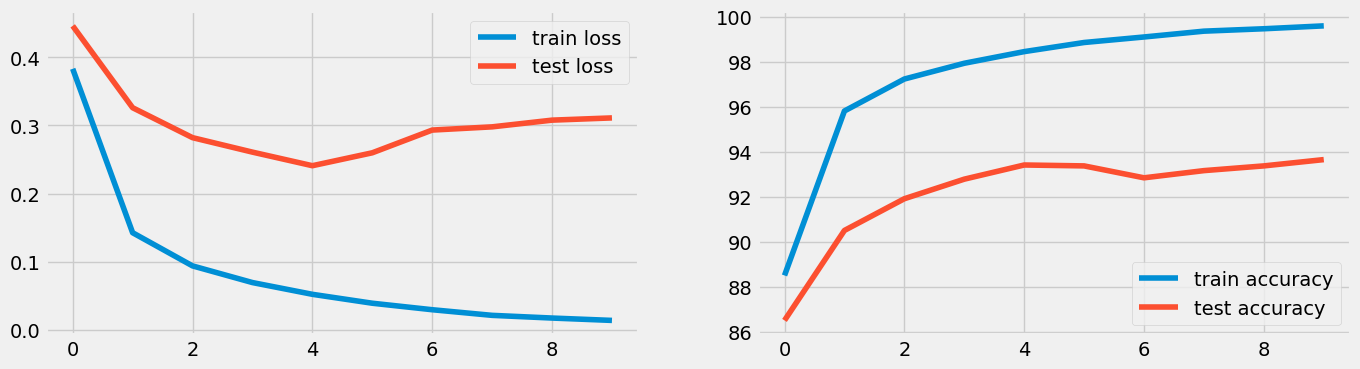

In [79]:
plot_loss_accs(ConvApolLinLin_Adam_result[0], ConvApolLinLin_Adam_result[2], ConvApolLinLin_Adam_result[1], ConvApolLinLin_Adam_result[3])

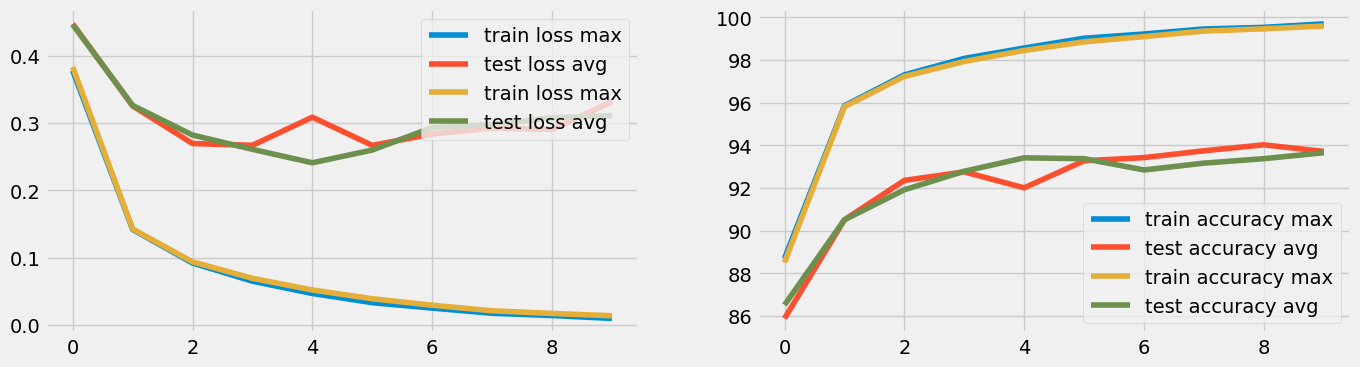

In [120]:
figure = plt.figure(figsize=(15,4))

labels = ["train loss max","test loss avg"]

plt.subplot(1,2,1)
plt.plot(ConvMpolLinLin_Adam_result[0],label = labels[0])
plt.plot(ConvMpolLinLin_Adam_result[2],label = labels[1])
plt.plot(ConvApolLinLin_Adam_result[0],label = labels[0])
plt.plot(ConvApolLinLin_Adam_result[2],label = labels[1])
plt.legend(loc="upper right")

labels = ["train accuracy max","test accuracy avg"]
plt.subplot(1,2,2)

plt.plot(ConvMpolLinLin_Adam_result[1],label = labels[0])
plt.plot(ConvMpolLinLin_Adam_result[3],label = labels[1])
plt.plot(ConvApolLinLin_Adam_result[1],label = labels[0])
plt.plot(ConvApolLinLin_Adam_result[3],label = labels[1])
plt.legend(loc="lower right")
plt.show()

Third model:
- Fully connected
- Fully connected
- Fully connected

Here's the number of neurons:
 - Input -> first fc = 28x28 
 - First fc -> second fc = 512
 - Second fc -> Third fc = 128
 - Third fc -> output = 10

 Tot = 1434  
 Tot n. of parameters = 468874

In [80]:
class LinLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(LinLinLin, self).__init__()

        self.l1 = nn.Linear(28*28, 512)  # 784 input features, 512 output features
        self.l2 = nn.Linear(512, 128)      # 512 input features, 128 output features
        self.l3 = nn.Linear(128, 10)  

    def forward(self, x):
        # flatten => BS x (28*28) = BS x 784
        x = x.view(-1, 28*28)
        
        # BSx784 => BSx512
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx512 => BSx128
        x = self.l2(x)

        x = F.relu(x)

        # BSx128 => BSx10
        out = self.l3(x)

        return out
    
    
model = LinLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 128]          65,664
            Linear-3                   [-1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


In [81]:
num_epochs = 10

model_LinLinLin_Adam = LinLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_LinLinLin_Adam.parameters(), lr=0.001)

LinLinLin_Adam_result = train_model(model_LinLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:06<00:00, 48.70it/s, acc=91.6, loss=0.56]  


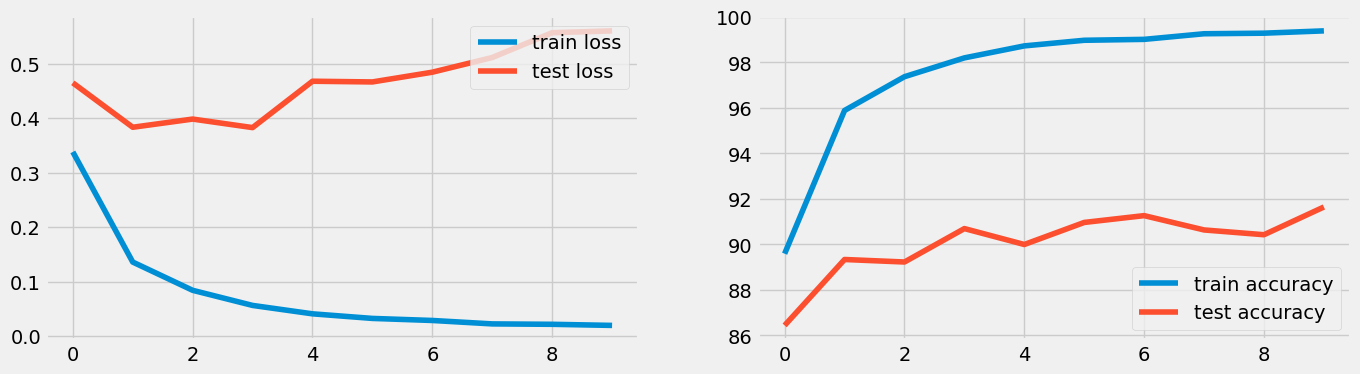

In [82]:
plot_loss_accs(LinLinLin_Adam_result[0], LinLinLin_Adam_result[2], LinLinLin_Adam_result[1], LinLinLin_Adam_result[3])

Fourth model:
- MaxPooling + Fully connected
- Fully connected
- Fully connected

Here's the number of neurons:
 - Input -> avgpooling = 28x28 
 - Maxpooling -> First fc = 14*14
 - First fc -> second fc = 128
 - Second fc -> Third fc = 64
 - Third fc -> output = 10

 Tot = 986  
 Tot n. of parameters = 34122

In [83]:
class MpolLinLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(MpolLinLinLin, self).__init__()

        self.mpol1 = nn.MaxPool2d(kernel_size=2)
        self.l1 = nn.Linear(14*14, 128)  # 784 input features, 512 output features
        self.l2 = nn.Linear(128, 64)      # 512 input features, 128 output features
        self.l3 = nn.Linear(64, 10)  

    def forward(self, x):

        # BSx28x28 => BSx14x14
        x = self.mpol1(x)

        # flatten => BS x (14*14) = BS x 196
        x = x.view(-1, 14*14)
        
        # BSx192 => BSx128
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx128 => BSx64
        x = self.l2(x)

        # Activation function
        x = F.relu(x)

        # BSx64 => BSx10
        out = self.l3(x)

        return out
    
model = MpolLinLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1            [-1, 1, 14, 14]               0
            Linear-2                  [-1, 128]          25,216
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 34,122
Trainable params: 34,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [84]:
num_epochs = 10

model_MpolLinLinLin_Adam = MpolLinLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_MpolLinLinLin_Adam.parameters(), lr=0.001)

MpolLinLinLin_Adam_result = train_model(model_MpolLinLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:06<00:00, 45.53it/s, acc=89.5, loss=0.454] 


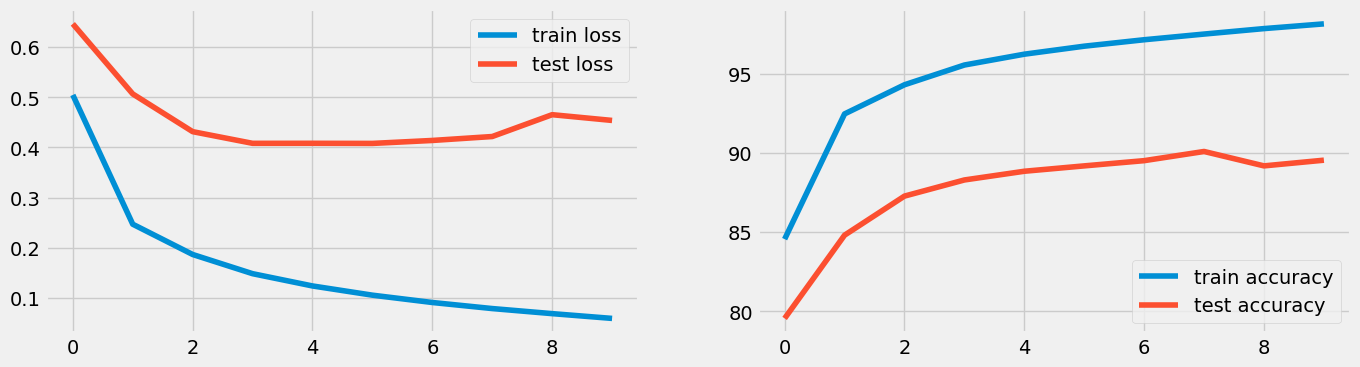

In [85]:
plot_loss_accs(MpolLinLinLin_Adam_result[0], MpolLinLinLin_Adam_result[2], MpolLinLinLin_Adam_result[1], MpolLinLinLin_Adam_result[3])

Fifth model:
- AvgPooling + Fully connected
- Fully connected
- Fully connected

Here's the number of neurons:
 - Input -> avgpooling = 28x28 
 - Avgpooling -> First fc = 14*14
 - First fc -> second fc = 128
 - Second fc -> Third fc = 64
 - Third fc -> output = 10

 Tot = 986  
 Tot n. of parameters = 34122

In [86]:
class ApolLinLinLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ApolLinLinLin, self).__init__()

        self.apol1 = nn.AvgPool2d(kernel_size=2)
        self.l1 = nn.Linear(14*14, 128)  # 784 input features, 512 output features
        self.l2 = nn.Linear(128, 64)      # 512 input features, 128 output features
        self.l3 = nn.Linear(64, 10)  

    def forward(self, x):

        # BSx28x28 => BSx14x14
        x = self.apol1(x)

        # flatten => BS x (14*14) = BS x 196
        x = x.view(-1, 14*14)
        
        # BSx192 => BSx128
        x = self.l1(x)

        # Activation function
        x = F.relu(x)

        # BSx128 => BSx64
        x = self.l2(x)

        # Activation function
        x = F.relu(x)

        # BSx64 => BSx10
        out = self.l3(x)

        return out
    
model = ApolLinLinLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool2d-1            [-1, 1, 14, 14]               0
            Linear-2                  [-1, 128]          25,216
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 34,122
Trainable params: 34,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [87]:
num_epochs = 10

model_ApolLinLinLin_Adam = ApolLinLinLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ApolLinLinLin_Adam.parameters(), lr=0.001)

ApolLinLinLin_Adam_result = train_model(model_ApolLinLinLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 43.13it/s, acc=89.7, loss=0.452] 


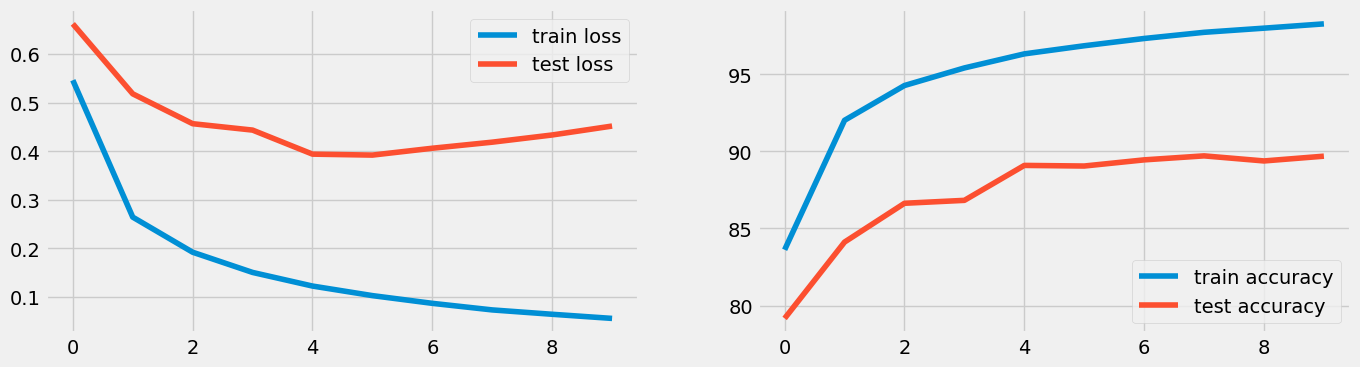

In [88]:
plot_loss_accs(ApolLinLinLin_Adam_result[0], ApolLinLinLin_Adam_result[2], ApolLinLinLin_Adam_result[1], ApolLinLinLin_Adam_result[3])

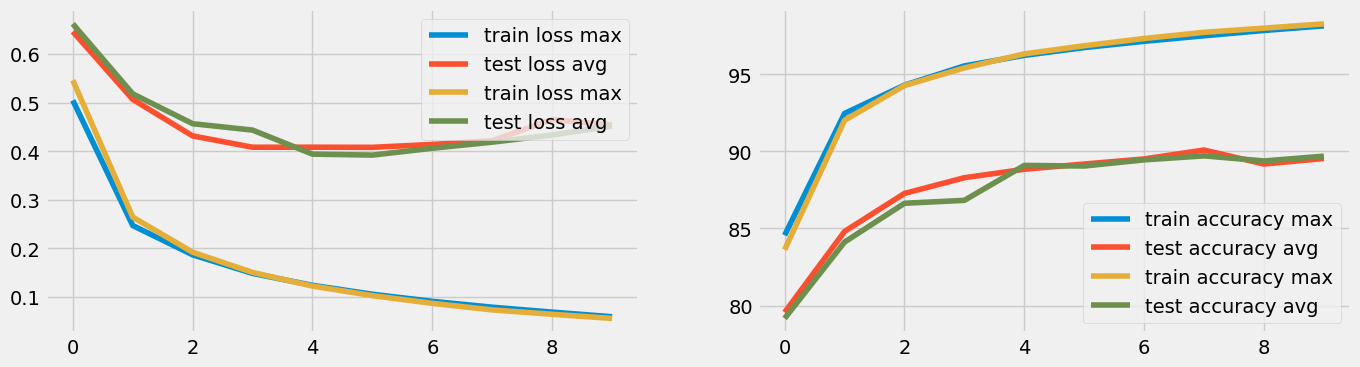

In [119]:
figure = plt.figure(figsize=(15,4))

labels = ["train loss max","test loss avg"]

plt.subplot(1,2,1)
plt.plot(MpolLinLinLin_Adam_result[0],label = labels[0])
plt.plot(MpolLinLinLin_Adam_result[2],label = labels[1])
plt.plot(ApolLinLinLin_Adam_result[0],label = labels[0])
plt.plot(ApolLinLinLin_Adam_result[2],label = labels[1])
plt.legend(loc="upper right")

labels = ["train accuracy max","test accuracy avg"]
plt.subplot(1,2,2)

plt.plot(MpolLinLinLin_Adam_result[1],label = labels[0])
plt.plot(MpolLinLinLin_Adam_result[3],label = labels[1])
plt.plot(ApolLinLinLin_Adam_result[1],label = labels[0])
plt.plot(ApolLinLinLin_Adam_result[3],label = labels[1])
plt.legend(loc="lower right")
plt.show()

Sixth model:
- Convolutional + MaxPooling
- Convolutional + MaxPooling
- Fully connected

Here's the number of neurons:
 - Input -> First convolutional + maxpooling = 28x28
 - First convolutional + maxpooling -> second convolutional + maxpooling = 32x14x14
 - Second convolutional + maxpooling -> fc = 64x7x7
 - Fc -> output = 10

 Tot = 3930  
 Tot n. of parameters = 50,186

In [122]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.relu(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.relu(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

model = ConvMpolConvMpolLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.19
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [129]:
num_epochs = 10

model_ConvMpolConvMpolLin_Adam = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ConvMpolConvMpolLin_Adam.parameters(), lr=0.0001)

ConvMpolConvMpolLin_Adam_result = train_model(model_ConvMpolConvMpolLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 41.28it/s, acc=90.3, loss=0.344] 


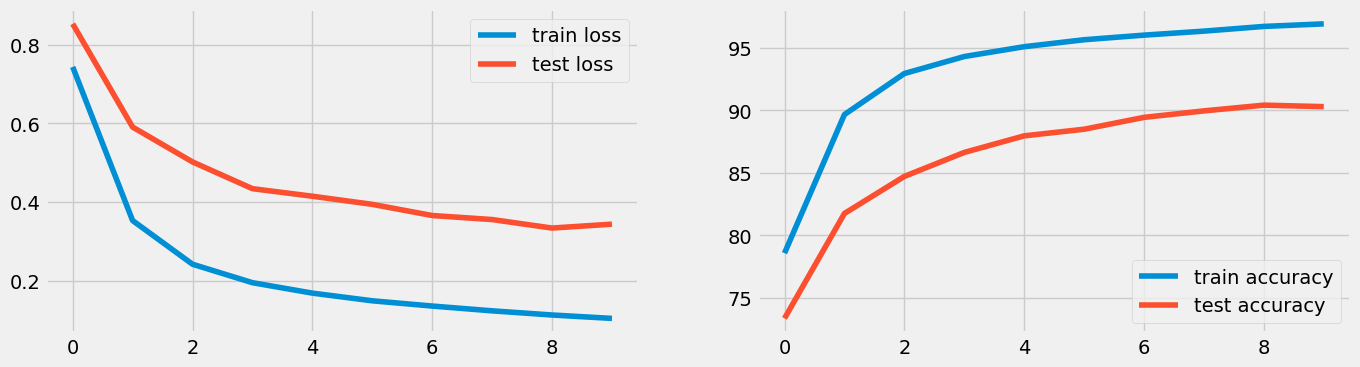

In [130]:
plot_loss_accs(ConvMpolConvMpolLin_Adam_result[0], ConvMpolConvMpolLin_Adam_result[2], ConvMpolConvMpolLin_Adam_result[1], ConvMpolConvMpolLin_Adam_result[3])

Seventh model:
- Convolutional + AvgPooling
- Convolutional + AvgPooling
- Fully connected

Here's the number of neurons:
 - Input -> First convolutional + avgpooling = 28x28
 - First convolutional + avgpooling -> second convolutional + avgpooling = 32x14x14
 - Second convolutional + avgpooling -> fc = 64x7x7
 - Fc -> output = 10

 Tot = 3930  
 Tot n. of parameters = 50,186

In [125]:
class ConvApolConvApolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvApolConvApolLin, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 28, 28)
        self.apol1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.apol2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.relu(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.apol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.relu(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.apol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out
    
model = ConvApolConvApolLin().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         AvgPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         AvgPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.19
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [126]:
num_epochs = 10

model_ConvApolConvApolLin_Adam = ConvApolConvApolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.Adam(model_ConvApolConvApolLin_Adam.parameters(), lr=0.0005)

ConvApolConvApolLin_Adam_result = train_model(model_ConvApolConvApolLin_Adam, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 41.58it/s, acc=92.9, loss=0.285] 


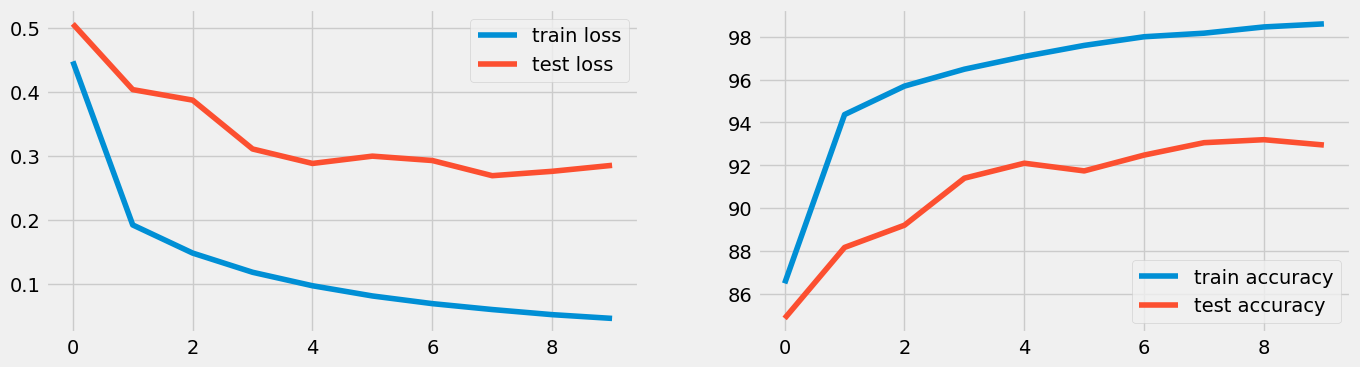

In [127]:
plot_loss_accs(ConvApolConvApolLin_Adam_result[0], ConvApolConvApolLin_Adam_result[2], ConvApolConvApolLin_Adam_result[1], ConvApolConvApolLin_Adam_result[3])

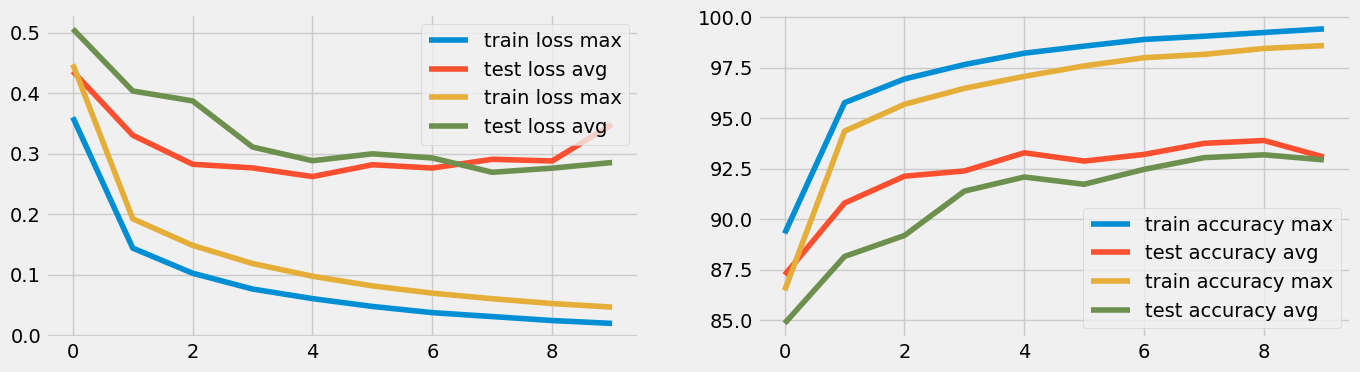

In [128]:
figure = plt.figure(figsize=(15,4))

labels = ["train loss max","test loss avg"]

plt.subplot(1,2,1)
plt.plot(ConvMpolConvMpolLin_Adam_result[0],label = labels[0])
plt.plot(ConvMpolConvMpolLin_Adam_result[2],label = labels[1])
plt.plot(ConvApolConvApolLin_Adam_result[0],label = labels[0])
plt.plot(ConvApolConvApolLin_Adam_result[2],label = labels[1])
plt.legend(loc="upper right")

labels = ["train accuracy max","test accuracy avg"]
plt.subplot(1,2,2)

plt.plot(ConvMpolConvMpolLin_Adam_result[1],label = labels[0])
plt.plot(ConvMpolConvMpolLin_Adam_result[3],label = labels[1])
plt.plot(ConvApolConvApolLin_Adam_result[1],label = labels[0])
plt.plot(ConvApolConvApolLin_Adam_result[3],label = labels[1])
plt.legend(loc="lower right")
plt.show()

Overall, the model that has obtained the most promising results is:
- 2 Convolutional 2d + 2 Max pooling + 1 linear layer

I will experiment with different optimizers, learning rates and epochs to see if I can achieve better results or if I have already reached the optimal performance with the 3 layer limit.

### Different optimizer

#### RMSprop

In [96]:
num_epochs = 10

model_ConvMpolConvMpolLin_RMSprop = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.RMSprop(model_ConvMpolConvMpolLin_RMSprop.parameters(), lr=0.0005)

ConvMpolConvMpolLin_RMSprop_result = train_model(model_ConvMpolConvMpolLin_RMSprop, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 41.71it/s, acc=93, loss=0.338]   


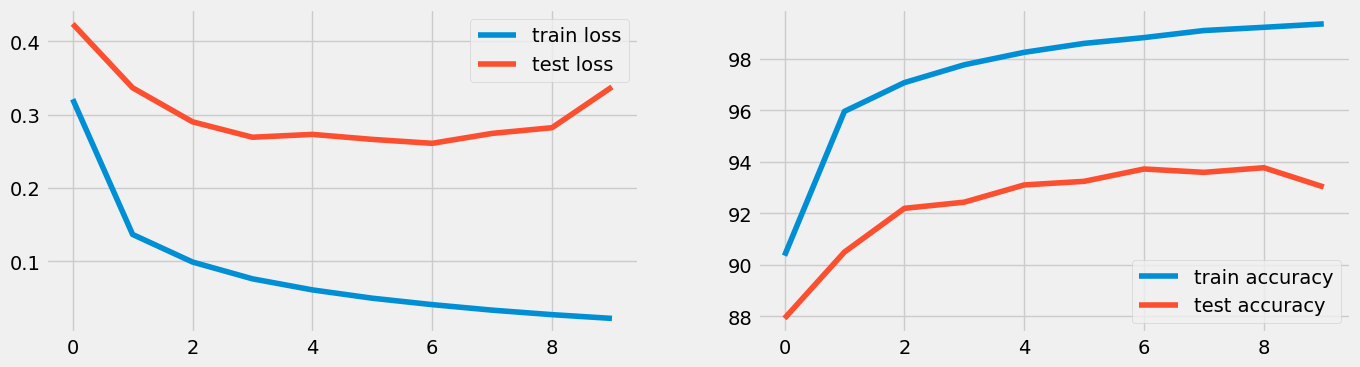

In [97]:
plot_loss_accs(ConvMpolConvMpolLin_RMSprop_result[0], ConvMpolConvMpolLin_RMSprop_result[2], ConvMpolConvMpolLin_RMSprop_result[1], ConvMpolConvMpolLin_RMSprop_result[3])

In [98]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.tanh(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.tanh(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

In [99]:
num_epochs = 10

model_ConvMpolConvMpolLin_RMSprop = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.RMSprop(model_ConvMpolConvMpolLin_RMSprop.parameters(), lr=0.0003)

ConvMpolConvMpolLin_RMSprop_result = train_model(model_ConvMpolConvMpolLin_RMSprop, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 42.49it/s, acc=92.5, loss=0.294] 


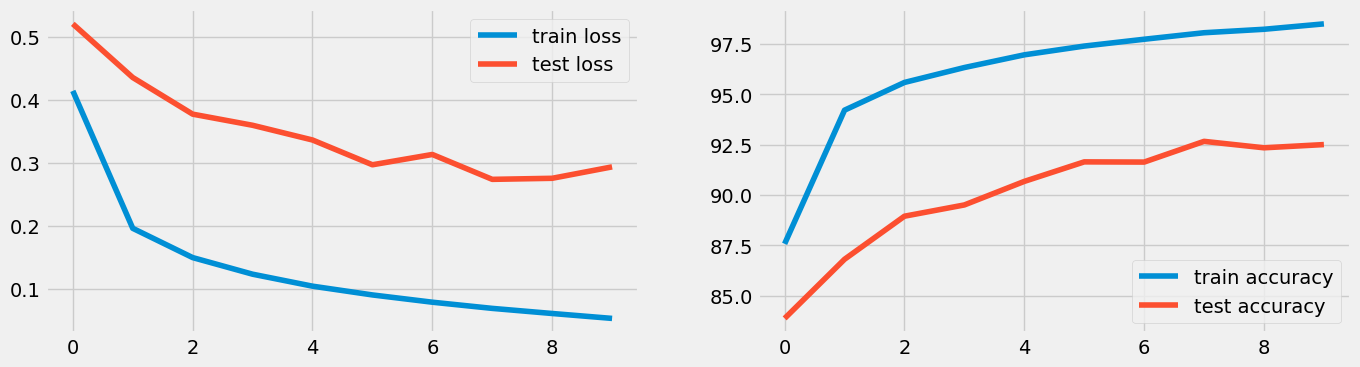

In [100]:
plot_loss_accs(ConvMpolConvMpolLin_RMSprop_result[0], ConvMpolConvMpolLin_RMSprop_result[2], ConvMpolConvMpolLin_RMSprop_result[1], ConvMpolConvMpolLin_RMSprop_result[3])

In [101]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.sigmoid(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.sigmoid(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

In [102]:
num_epochs = 10

model_ConvMpolConvMpolLin_RMSprop = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.RMSprop(model_ConvMpolConvMpolLin_RMSprop.parameters(), lr=0.0005)

ConvMpolConvMpolLin_RMSprop_result = train_model(model_ConvMpolConvMpolLin_RMSprop, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 42.85it/s, acc=89.1, loss=0.39]  


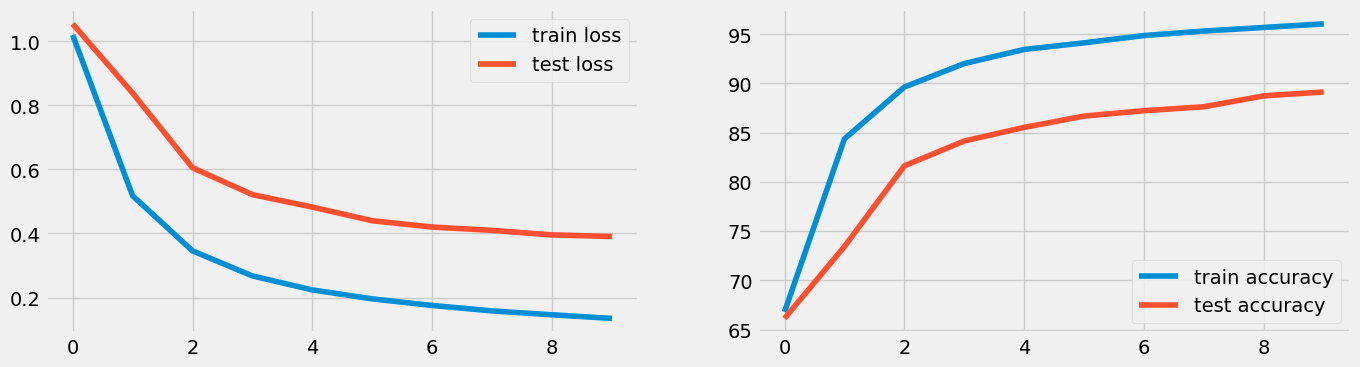

In [103]:
plot_loss_accs(ConvMpolConvMpolLin_RMSprop_result[0], ConvMpolConvMpolLin_RMSprop_result[2], ConvMpolConvMpolLin_RMSprop_result[1], ConvMpolConvMpolLin_RMSprop_result[3])

#### SGD

In [104]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.relu(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.relu(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

In [105]:
num_epochs = 10

model_ConvMpolConvMpolLin_SGD = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.SGD(model_ConvMpolConvMpolLin_SGD.parameters(), lr=0.001)

ConvMpolConvMpolLin_SGD_result = train_model(model_ConvMpolConvMpolLin_SGD, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 42.46it/s, acc=75.1, loss=0.789] 


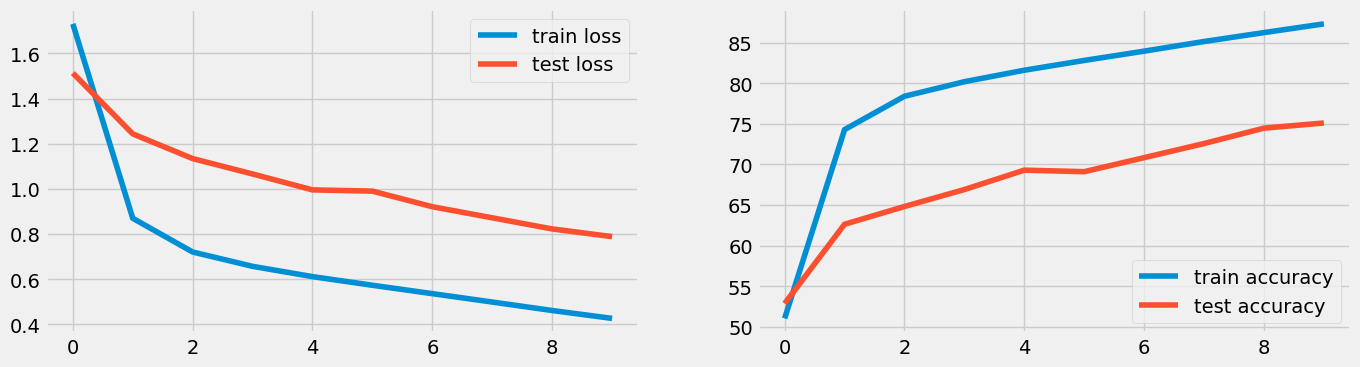

In [106]:
plot_loss_accs(ConvMpolConvMpolLin_SGD_result[0], ConvMpolConvMpolLin_SGD_result[2], ConvMpolConvMpolLin_SGD_result[1], ConvMpolConvMpolLin_SGD_result[3])

In [107]:
num_epochs = 10

model_ConvMpolConvMpolLin_SGD = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.SGD(model_ConvMpolConvMpolLin_SGD.parameters(), lr=0.01)

ConvMpolConvMpolLin_SGD_result = train_model(model_ConvMpolConvMpolLin_SGD, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 40.33it/s, acc=90.5, loss=0.333] 


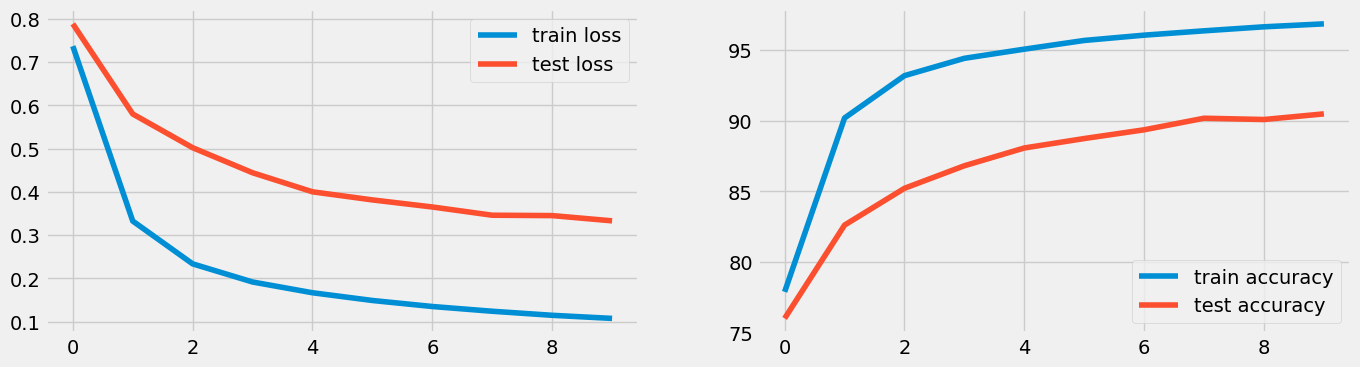

In [108]:
plot_loss_accs(ConvMpolConvMpolLin_SGD_result[0], ConvMpolConvMpolLin_SGD_result[2], ConvMpolConvMpolLin_SGD_result[1], ConvMpolConvMpolLin_SGD_result[3])

In [109]:
num_epochs = 10

model_ConvMpolConvMpolLin_SGD = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.SGD(model_ConvMpolConvMpolLin_SGD.parameters(), lr=0.05)

ConvMpolConvMpolLin_SGD_result = train_model(model_ConvMpolConvMpolLin_SGD, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 41.86it/s, acc=93.2, loss=0.301] 


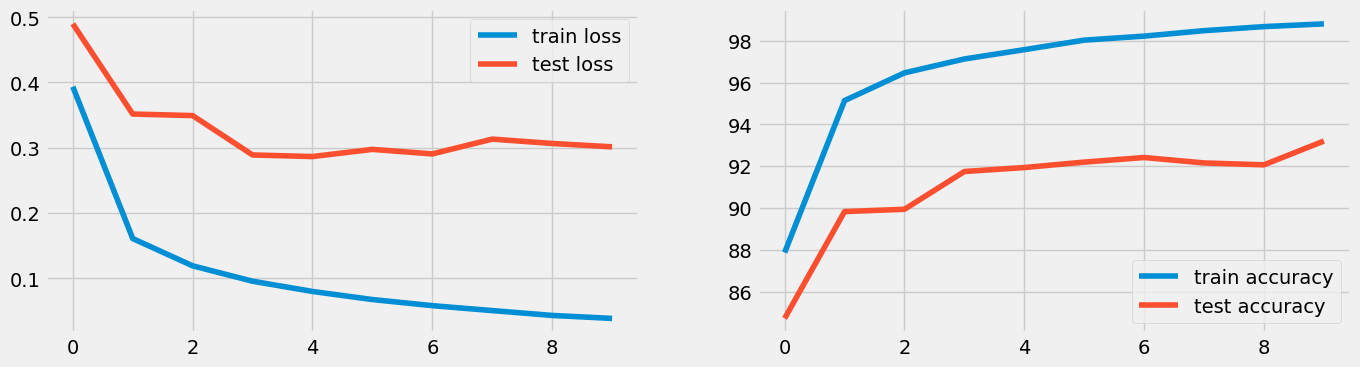

In [110]:
plot_loss_accs(ConvMpolConvMpolLin_SGD_result[0], ConvMpolConvMpolLin_SGD_result[2], ConvMpolConvMpolLin_SGD_result[1], ConvMpolConvMpolLin_SGD_result[3])

In [111]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.tanh(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.tanh(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

In [112]:
num_epochs = 10

model_ConvMpolConvMpolLin_SGD = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.SGD(model_ConvMpolConvMpolLin_SGD.parameters(), lr=0.05)

ConvMpolConvMpolLin_SGD_result = train_model(model_ConvMpolConvMpolLin_SGD, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 41.75it/s, acc=92.9, loss=0.265] 


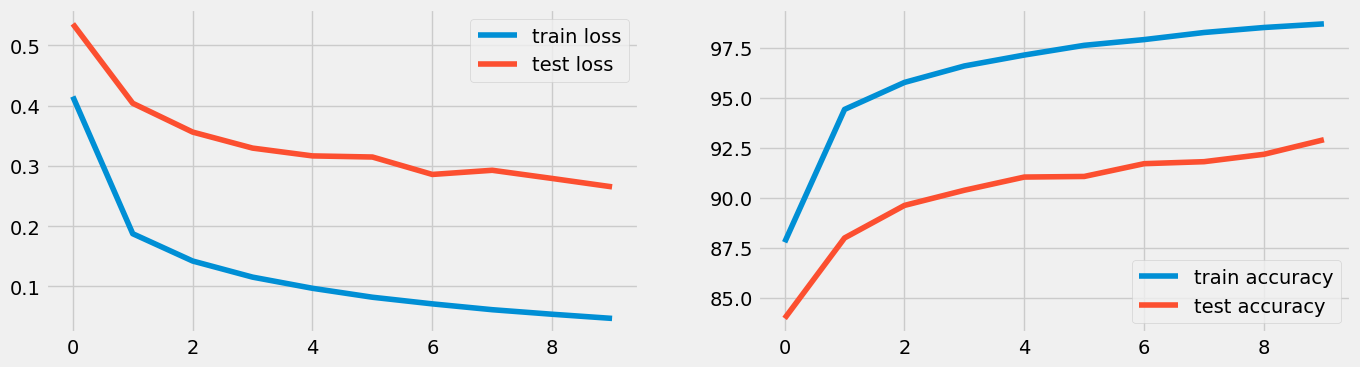

In [113]:
plot_loss_accs(ConvMpolConvMpolLin_SGD_result[0], ConvMpolConvMpolLin_SGD_result[2], ConvMpolConvMpolLin_SGD_result[1], ConvMpolConvMpolLin_SGD_result[3])

In [114]:
class ConvMpolConvMpolLin(nn.Module):
    # YOUR CODE
    def __init__(self):
        super(ConvMpolConvMpolLin, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: (BS, 32, 26, 26)
        self.mpol1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (BS, 64, 14, 14)
        self.mpol2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (BS, 64, 7, 7)
        self.l1 = nn.Linear(64 * 7 * 7, 10)  # Input: 3136, Output: 10

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        
        # Activation function
        x = F.sigmoid(x)

        # BSx32x26x26 => BSx32x14x14
        x = self.mpol1(x)

        # Convolution: BSx32x14x14 => BSx64x14x14
        x = self.conv2(x)

        # Activation function
        x = F.sigmoid(x)

        # BSx64x14x14 => BSx64x7x7
        x = self.mpol2(x)

        # flatten => BS x (64*7*7) = BS x 3136
        x = x.flatten(start_dim = 1)

        # BSx(64*7*7) => BSx10
        out = self.l1(x)

        return out

In [115]:
num_epochs = 10

model_ConvMpolConvMpolLin_SGD = ConvMpolConvMpolLin().to(device)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = t.optim.SGD(model_ConvMpolConvMpolLin_SGD.parameters(), lr=0.05)

ConvMpolConvMpolLin_SGD_result = train_model(model_ConvMpolConvMpolLin_SGD, num_epochs, trainloader, testloader, criterion, optimizer)

Test Epoch: 	[10/10]: 100%|██████████| 313/313 [00:07<00:00, 42.24it/s, acc=82.9, loss=0.551] 


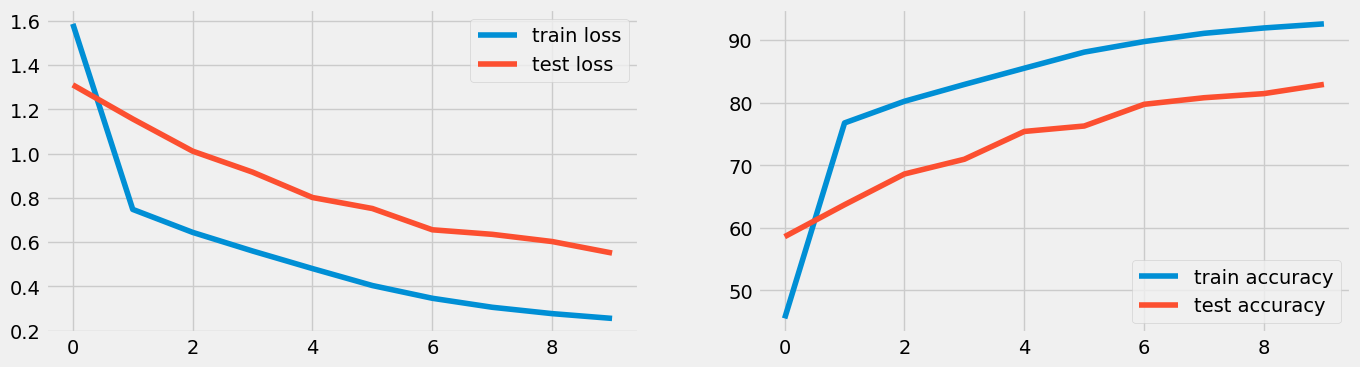

In [116]:
plot_loss_accs(ConvMpolConvMpolLin_SGD_result[0], ConvMpolConvMpolLin_SGD_result[2], ConvMpolConvMpolLin_SGD_result[1], ConvMpolConvMpolLin_SGD_result[3])

## 3. Summarise your results in a table and comment on them in the report.

Different models, same optimizer, 10 epochs:

| Modello | Training loss | Training accuracy | Test loss | Test accuracy | Optimizer | Learning rate | N. parameters |
|-----------|-----------|-----------|-----------|-----------|-----------| -----------| -----------|
| Convolutional <br /> Fully connected <br /> Fully connected | 0.00565      | 99.8      | 0.586     | 91      | Adam      | 0.001      | 2,770,634 |
| Convolutional + Maxpooling <br /> Fully connected <br /> Fully connected | 0.00987      | 99.7      | 0.331      | 93.7      | Adam      | 0.001      | 263,882 |
| Convolutional + Avgpooling <br /> Fully connected <br /> Fully connected      | 0.0138      | 99.6      | 0.311      | 93.7      | Adam      | 0.001      | 263,882 |
| Fully connected <br /> Fully connected  <br /> Fully connected      | 0.0197      | 99.4      | 0.56      | 91.6      | Adam      | 0.001      | 468,874 |
| Maxpooling + Fully connected <br /> Fully connected <br /> Fully connected |   0.0595    | 98.1      | 0.454      | 89.5      | Adam      | 0.001      | 34,122 |
| Avgpooling + Fully connected <br /> Fully connected <br /> Fully connected      | 0.0561      | 98.3      | 0.452      | 89.7      | Adam      | 0.001      | 34,122 |
| Convolutional + Maxpooling <br /> Convolutional + Maxpooling <br /> Fully connected      | 0.0121      | 99.6      |   0.33    | 94.2      | Adam      | 0.001      | 50,186 |
| Convolutional + Avgpooling <br /> Convolutional + Avgpooling <br /> Fully connected      |     |


Different parameters, same model (Convolutional + Maxpooling, Convolutional + Maxpooling, Fully connected), 10 epochs

| Optimizer | Learning rate | Activation function | Training loss | Training accuracy | Test loss | Test accuracy |
|-----------|-----------|-----------|-----------|-----------|-----------| -----------| 
| RMSprop | 0.0005 | Adam      | 0.0219   | 99.4      | 0.338 | 93     | 
| RMSprop | 0.0003 | tanh      | 0.0482    | 98.7     | 0.263 | 92.9     |
| RMSprop | 0.0005 | sigmoid     | 0.13     | 96      | 0.386 | 88.5     |
| SGD | 0.001 | Adam | 0.448      | 86.8      | 0.82    | 74.2     | 
| SGD | 0.01 | Adam | 0.105     | 97      | 0.334     | 90.5      | 
| SGD | 0.05 | Adam |  0.0378  |  98.9  |  0.288  | 92.9  | 
| SGD | 0.05 | tanh |  0.0477  |  98.7  |  0.28 |  92.5  | 
| SGD | 0.05 | sigmoid |  0.241 | 92.9   |  0.544 |  83.1  | 

## 4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.